# AIR QUALITY HACKATHON

In [1]:
# !pip install catboost
# !pip install optuna
# !pip install geopy

### Mount your Google Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## All the necessary Libraries

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as catt
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split, KFold,GroupKFold

from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = 2200
pd.options.display.max_columns = 2200

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import optuna

from geopy.geocoders import Nominatim
from geopy.point import Point
import requests
from io import StringIO 

/home/koleshjr/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load the data

In [4]:
# Load files
path= './'
train = pd.read_csv(path + 'train.csv', parse_dates = ['date'])
test = pd.read_csv(path + 'test.csv', parse_dates = ['date'])
sub= pd.read_csv(path+ 'SampleSubmission.csv')


train.shape, test.shape

((9923, 71), (4254, 70))

#### We have 69 independent features 

In [5]:
train.head()

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5
0,ID_JBYXJEUZ8X,2020-03-18,ANQ16PZJ,0.35346,32.56032,0.84684,22.03854,-0.00014,1.04263,-0.00014,0.29136,76.59491,10.25336,-93.09162,19.18137,-0.00001,0.03374,2457.11182,1353.66467,829636.00000,70.37299,10.31243,-93.00801,19.19493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00012,1.54410,0.00009,0.29136,19.18137,-93.09162,10.25336,76.59491,-1.64226,829649.46231,76.61416,10.02307,-93.10610,19.20809,0.11678,2.08862,0.24753,228.15512,0.41042,76.61416,10.02307,-93.10610,19.20809,0.43680,61535.80469,4181.79297,69589.45312,3181.79346,7.79985,0.27811,76.61855,9.97029,-93.11007,19.21419,63.85333
1,ID_PEJJNLBUPR,2019-10-13,AB6051M4,0.39074,32.58226,0.87449,21.54583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.21781,829826.62500,-97.72382,58.45699,-103.69569,36.37274,0.11728,3.03799,0.35978,226.43236,0.46068,-97.72382,58.45699,-103.69569,36.37274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.50708
2,ID_21L8UZQO1T,2019-12-21,A0WN66FH,0.28575,32.57833,0.72934,23.56866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03342,1810.82390,3233.82780,829918.44333,-95.67473,63.74221,-127.83769,40.85469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.69156,829964.43750,-97.30075,63.69049,-127.85683,40.85789,0.10982,3.48342,0.38566,223.47685,0.65635,-97.30075,63.69049,-127.85683,40.85789,0.65746,59516.62500,4440.39111,67341.10938,3440.39087,62.49659,0.41663,-97.30076,63.69061,-127.85680,40.85792,80.29083
3,ID_GNW2G8J4T8,2020-02-20,aq_41,-1.24499,29.98924,0.91927,16.33854,-0.00011,0.75023,-0.00008,0.00000,75.78989,20.79486,-121.23973,19.20125,-0.00004,0.02980,2402.93091,2578.23950,829764.62500,72.60018,21.02760,-121.22385,1

### Sort the Data because satelite date is timeseries like

In [6]:
train = train.sort_values(by=['date']).reset_index(drop=True)
test = test.sort_values(by=['date']).reset_index(drop=True)

In [7]:
train.date.max(),train.date.min()

(Timestamp('2020-08-20 00:00:00'), Timestamp('2019-03-14 00:00:00'))

In [8]:
test.date.max(),test.date.min()

(Timestamp('2020-12-31 00:00:00'), Timestamp('2020-08-20 00:00:00'))

In [9]:
train[train.date == '2020-08-20 00:00:00']

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5
9916,ID_6KS7V1SNDE,2020-08-20,aq_74,0.30749,32.61176,0.78854,23.47065,0.00004,0.90188,0.00004,0.28179,75.39268,24.54683,-56.48190,21.99469,0.00002,0.04728,2749.19458,3291.66309,829581.75000,72.62214,24.46817,-56.54374,22.01058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00037,1.08161,0.00034,0.28179,21.99469,-56.48190,24.54683,75.39268,-2.05664,829601.56250,75.39268,24.54683,-56.48190,21.99469,0.12131,2.19763,0.27105,225.54852,0.28179,75.39268,24.54683,-56.48190,21.99469,0.28254,63514.91797,3990.08545,71193.43750,2990.08545,3.44774,0.21952,75.39268,24.54668,-56.48193,21.99471,52.59262
9917,ID_1QUYP11XTV,2020-08-20,aq_64,0.39148,32.62583,0.90244,20.42778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.52059,829588.37500,75.41217,24.25663,-56.73928,21.95290,0.12074,2.19757,0.26975,222.59970,0.80406,75.41217,24.25663,-56.73928,21.95290,0.80485,42004.47656,7319.07227,47475.18750,6319.07227,5.91147,0.25037,75.41216,24.25648,-56.73931,21.95291,49.98880
9918,ID_FCD1L3F8X0,2020-08-20,AR2RHV97,0.34373,32.55131,0.83145,21.79514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04244,3733.55396,4540.65039,829575.25000,72.62525,25.04499,-56.48653,21.92781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.71050,829591.05715,75.36421,24.83648,-56.55353,21.91643,0.12101,2.20061,0.27060,222.75447,0.73935,75.36421,24.83648,-56.55353,21.91643,0.54225,42298.32216,7239.25396,47831.25022,6239.25392,4.49200,0.23732,75.36556,24.83648,-56.50868,21.93276,84.79917
9919,ID_W1RFPTL457,2020-08-20,aq_29,0.30750,32.62060,0.80628,22.70104,0.00004,0.90188,0.00004,0.28179,75.39268,24.54683,-56.48190,21.99469,0.00002,0.04728,2749.19458,329

In [10]:
test[test.date == '2020-08-20 00:00:00']

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_OC21YTIKX2,2020-08-20,AB6051M4,0.39074,32.58226,0.88728,21.31544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.10931,829588.37500,75.38764,24.54639,-56.66567,21.92779,0.12012,2.20434,0.26922,225.18874,0.98004,75.38764,24.54639,-56.66567,21.92779,0.98030,45320.93359,6711.70166,51283.30078,5711.70166,8.07239,0.26082,75.38763,24.54624,-56.66571,21.92780
1,ID_ZS2RAN8HZT,2020-08-20,AKSLS0FP,0.26501,32.62560,0.80628,22.70104,0.00005,0.87969,0.00005,0.25194,75.39356,24.54438,-56.45775,22.00400,0.00002,0.05241,2197.49829,3811.32593,829588.37500,72.62483,24.46825,-56.45232,22.04409,0.00009,0.00004,0.00003,0.00014,9580.24591,-2.14782,0.14135,829603.32398,75.39356,24.54438,-56.45775,22.00400,0.00034,1.07779,0.00030,0.25194,22.00400,-56.45775,24.54438,75.39356,-2.14783,829603.32398,75.39356,24.54438,-56.45775,22.00400,0.12107,2.19678,0.27041,225.58720,0.25214,75.39356,24.54438,-56.45775,22.00400,0.23072,59601.65796,4502.30597,67131.81147,3502.30607,2.58308,0.19523,75.39382,24.54672,-56.43937,22.01032
2,ID_X5RLD131U1,2020-08-20,aq_35,0.36075,32.75257,0.87799,21.64201,0.00009,0.85311,0.00007,0.10405,75.48886,23.38893,-56.83083,22.07349,0.00004,0.04444,2638.21580,3024.08958,829575.24497,72.59908,23.31786,-56.92641,22.07516,0.00005,0.00002,0.00003,0.00009,9580.24596,-2.34794,0.03962,829597.34172,75.48886,23.38893,-56.83083,22.07349,0.00026,1.08651,0.00022,0.10405,22.07349,-56.83083,23.38893,75.48886,-2.34794,829597.34172,75.48886,23.38893,-56.83083,22.07349,0.12079,2.17998,0.26806,226.41505,0.09824,75.48886,23.38893,-56.83083,22.07349,0.09313,50779.85156,5769.06201,58071.79687,4769.06201,1.97666,0.22146,75.48805,23.38873,-56.86483,22.06116
3,ID_3

In [11]:
# train['date'].value_counts()

## Statistical Data

In [12]:
# train.describe().T

In [13]:
# train.info()

#### 68 numeric features, two object features and one datetime

### Missing Values

In [14]:
#check for missing values
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_train = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})
missing_value_train

,column_name,percent_missing
ID,ID,0.00000
date,date,0.00000
device,device,0.00000
site_latitude,site_latitude,0.00000
site_longitude,site_longitude,0.00000
humidity,humidity,0.00000
temp_mean,temp_mean,0.20155
SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density,56.75703
SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_column_number_density_amf,56.75703
SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_SO2_slant_column_number_density,56.75703


### Quite a number of missing values with the highest being 68%
* you can FFILL them or Use LGBM imputer to do that for you

In [15]:
cat_columns = [col for col in train.select_dtypes('object').columns]

num_columns = [col for col in train.select_dtypes(['int', 'float']).columns if col not in ['pm2_5']]

In [16]:
# test =test.ffill()
# train = train.ffill()


In [17]:
# #check for missing values
# percent_missing = train.isnull().sum() * 100 / len(train)
# missing_value_train = pd.DataFrame({'column_name': train.columns,
#                                  'percent_missing': percent_missing})
# missing_value_train

####  Nice all the miss values handled

## concat train and test

In [18]:
#CONCATENATING BOTH THE TEST AND TRAIN FOR EASY DATA MANIPULATON
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

### Outliers

In [19]:
limitPer = len(data) * .40
output = data.dropna(thresh=limitPer, axis=1)
data = output.copy()

In [20]:
#check for missing values
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_train = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_train

,column_name,percent_missing
ID,ID,0.00000
date,date,0.00000
device,device,0.00000
site_latitude,site_latitude,0.00000
site_longitude,site_longitude,0.00000
humidity,humidity,0.00000
temp_mean,temp_mean,0.14107
CarbonMonoxide_CO_column_number_density,CarbonMonoxide_CO_column_number_density,46.63892
CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_H2O_column_number_density,46.63892
CarbonMonoxide_cloud_height,CarbonMonoxide_cloud_height,46.63892


In [21]:
nan_cols = [c for c in data.columns if c not in ["ID","pm2_5", "device"]]
nan_cols = data[nan_cols].columns[data[nan_cols].isnull().any()].tolist()

for col in nan_cols:
    
    while data[col].isnull().sum()>0:
     
        data[col].fillna(data[["device", col]].groupby(["device"]).shift(periods=0).fillna(method='ffill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True) 

data.isnull().sum()[data.isnull().sum()>0]

pm2_5    4254
dtype: int64

In [22]:
cat_columns = [col for col in data.select_dtypes('object').columns]

num_columns = [col for col in data.select_dtypes(['int', 'float']).columns if col not in ['pm2_5']]

In [23]:
skewed = num_columns
data[skewed].describe(percentiles=[0.05,0.95])

,site_latitude,site_longitude,humidity,temp_mean,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
count,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000,14177.00000
mean,0.25134,32.48278,0.79275,21.49991,0.03406,2737.85892,2769.47320,829659.29293,-17.19822,38.73030,-93.23924,28.47478,0.00014,1.11949,0.00008,0.24113,28.17159,-93.80608,39.23009,-15.99219,-1.42363,829638.53779,-14.03174,40.43434,-93.63946,27.89461,0.11654,2.61699,0.30961,228.64059,0.52001,-15.46145,40.32058,-93.75388,28.05324,0.53318,50357.87893,6245.00835,56474.29302,5303.38570,17.45373,0.26692,-15.01948,40.53296,-93.75894,27.98806
std,0.31757,0.52040,0.15020,3.87594,0.00610,1129.83884,1371.29524,220.61693,82.97884,18.47461,37.02536,6.77642,0.00014,0.31284,0.00013,0.13765,6.65550,37.97072,19.58769,86.68180,0.73643,231.62926,86.61026,19.50569,38.54450,6.97099,0.00377,0.41077,0.04849,3.89299,0.34839,86.59266,19.38525,38.32244,6.91668,0.34154,17622.11679,2949.36891,18504.94048,2866.61569,31.53740,0.05527,86.57674,19.20584,38.51865,6.90825
min,-1.24499,29.98924,0.00000,0.00000,0.01927,790.61725,-200.15250,829145.50000,-98.19382,1.10796,-157.29324,9.83084,-0.00060,0.37248,-0.00055,0.00000,8.70309,-160.28487,0.10093,-106.86002,-6.43919,829156.68750,-107.00089,0.06219,-160.32117,8.21253,0.10563,2.03860,0.22737,187.58493,0.00000,-107.00089,0.06219,-160.28487,8.38863,0.00006,12711.38867,1150.14993,15003.53516,1150.14993,1.25037,0.01239,-106.80888,0.06208,-160.28479,8.38750
5%,0.05960,32.46032,0.56792,16.74571,0.02597,1607.25317,209.60792,829273.06250,-98.06603,3.86038,-144.31586,16.24537,-0.00007,0.66825,-0.00013,0.00000,15.68860,-146.46895,3.27906,-102.69110,-2.58109,829241.91250,-102.68435,3.24765,-147.22266,15.10388,0.10965,2.12833,0.24768,222.73779,0.02626,-102.68435,3.24765,-147.44492,15.28238,0.06688,22703.09180,1997.71886,26367.87745,1296.53685,2.88709,0.19025,-102.65934,3.28012,-147.86221,15.28662
50%,0.31545,32.58958,0.82266,22.18949,0.03315,2471.72729,2922.65723,829710.43750,-79.67454,42.99375,-99.32306,28.86836,0.00013,1.06437,0.00008,0.23771,28.84133,-98.93428,43.74133,-97.29314,-1.44291,829686.31250,-97.26748,44.37339,-99.97107,28.29652,0.11703,2.52023,0.29903,228.72275,0.45747,-97.28765,44.38621,-99.92225,28.41042,

In [24]:
# for col in data.columns:
#     if col in num_columns:
#         plt.figure()
#         sns.displot(data[col])

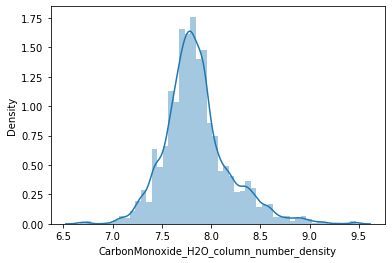

In [25]:
sns.distplot(np.log1p(data.CarbonMonoxide_H2O_column_number_density))

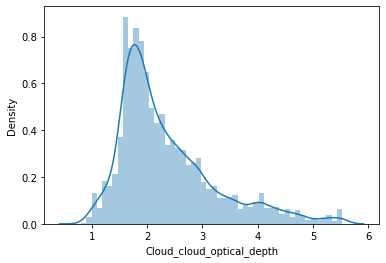

In [26]:
sns.distplot(np.log1p(data.Cloud_cloud_optical_depth))

#### Logging improves the above features, put that into consideration

In [27]:
temp_hum = ['temp_mean','humidity']
data[temp_hum].describe()

,temp_mean,humidity
count,14177.00000,14177.00000
mean,21.49991,0.79275
std,3.87594,0.15020
min,0.00000,0.00000
25%,21.16548,0.77513
50%,22.18949,0.82266
75%,23.13194,0.86669
max,29.73500,1.00000


### temperature and humidity are of the required range

## Visualizing our Target

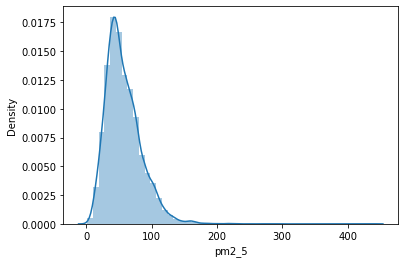

In [28]:
sns.distplot((data.pm2_5))

In [29]:
data.pm2_5.describe()

count   9923.00000
mean      57.10731
std       27.48295
min        1.16040
25%       38.02829
50%       51.93024
75%       72.03312
max      440.92000
Name: pm2_5, dtype: float64

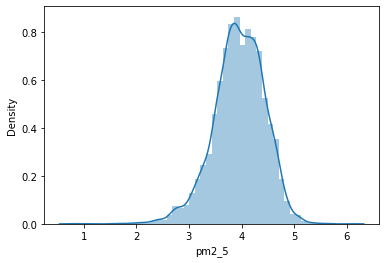

In [30]:
sns.distplot(np.log1p(data.pm2_5))

### Okay log transforming the target helps, so use this in your modelling
* doesn't help

In [31]:
skewed = ['pm2_5','CarbonMonoxide_H2O_column_number_density','Cloud_cloud_optical_depth']
data[skewed].describe(percentiles=[0.10,0.90])

,pm2_5,CarbonMonoxide_H2O_column_number_density,Cloud_cloud_optical_depth
count,9923.00000,14177.00000,14177.00000
mean,57.10731,2737.85892,17.45373
std,27.48295,1129.83884,31.53740
min,1.16040,790.61725,1.25037
10%,27.33535,1764.76831,3.68673
50%,51.93024,2471.72729,7.02214
90%,92.99733,4027.54331,37.99522
max,440.92000,12919.68511,250.00000


In [32]:

data['pm2_5'] = np.where(data['pm2_5']  >= data['pm2_5'].quantile(0.97), data['pm2_5'].quantile(0.97),data['pm2_5'])
# data['CarbonMonoxide_H2O_column_number_density'].loc[data['CarbonMonoxide_H2O_column_number_density'] >3074.94557]  = 5000
# data['Cloud_cloud_optical_depth'].loc[data['Cloud_cloud_optical_depth'] > 32.01707]  = 50

data['Cloud_cloud_optical_depth'] = np.where(data['Cloud_cloud_optical_depth']  >= data['Cloud_cloud_optical_depth'].quantile(0.97), data['Cloud_cloud_optical_depth'].quantile(0.97),data['Cloud_cloud_optical_depth'])

## Categorical Features

In [33]:
categorical_behaving_cols = ['device',
'site_latitude',
'site_longitude',]

In [34]:
# check unique values in dataset
data[categorical_behaving_cols].apply(lambda x: len(x.unique()))

device            36
site_latitude     48
site_longitude    36
dtype: int64

### Device

aq_30       598
aq_41       586
aq_45       500
aq_43       491
aq_46       486
aq_49       485
AKSLS0FP    462
A0WN66FH    462
AY2J2Q7Z    462
AB6051M4    462
AJCK5L86    462
APYZC5J7    462
ANQ16PZJ    462
AR2RHV97    462
APZ80RTM    462
AW66FF7V    462
A95X5F9T    462
aq_29       447
aq_54       417
aq_36       404
aq_61       400
aq_52       399
aq_59       395
aq_70       372
aq_35       348
aq_74       336
aq_47       332
aq_56       324
aq_31       314
aq_79       307
aq_60       295
aq_57       294
aq_76       245
aq_64       237
aq_91        80
aq_98         3
Name: device, dtype: int64


Text(0.5, 0, 'device')

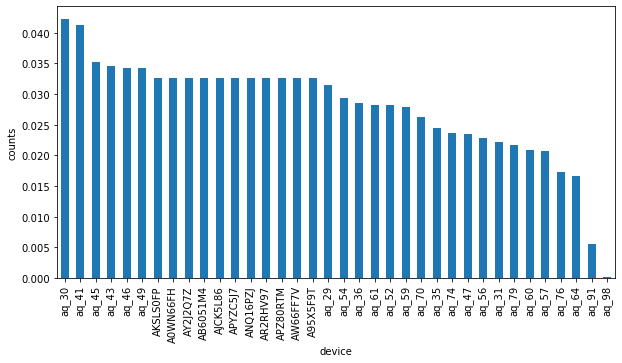

In [35]:
print(data['device'].value_counts())
plt.figure(figsize=(10,5))
data['device'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('device')

### All devices seem pretty balanced except for aq_98 and aq_91
* cluster the two into one see if it improves the model
* count_encode

### Site_Latitude

0.05960     598
-1.24499    586
0.34400     500
0.28904     491
0.29875     486
0.28368     485
0.26501     462
0.28575     462
0.30758     462
0.39074     462
0.34390     462
0.34373     462
0.30667     462
0.31545     462
0.31997     462
0.30750     447
0.35346     446
0.37956     444
0.35640     417
0.35483     404
0.28659     372
0.21820     371
0.37308     344
0.38158     339
0.30749     336
0.31010     324
0.36075     323
0.34701     314
0.36021     300
0.30778     295
0.35470     289
0.35799     245
0.39148     228
0.35170     200
0.35170     132
0.33261      83
0.38158      52
0.37308      49
0.21820      28
0.36075      25
0.35346      16
0.37956      12
0.39148       9
0.37308       7
0.36021       7
0.37956       6
0.35470       5
0.38158       4
Name: site_latitude, dtype: int64


Text(0.5, 0, 'site_latitude')

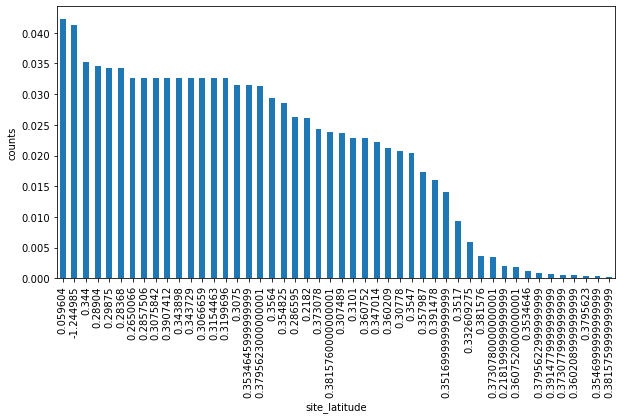

In [36]:
print(data['site_latitude'].value_counts())
plt.figure(figsize=(10,5))
data['site_latitude'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('site_latitude')

### Some are imbalanced
* geo_code
* count_encode

### Site_Longitude

32.46032    598
32.55300    500
32.58958    491
32.61500    486
32.60048    485
32.62560    462
32.57833    462
32.56708    462
32.58226    462
32.58723    462
32.59555    462
32.56032    462
32.55131    462
32.60855    462
32.58671    462
32.55371    462
32.62060    447
32.57300    417
32.67781    404
32.62823    400
32.61760    399
32.64711    395
32.50611    372
32.75257    348
32.61176    336
32.59100    332
29.98924    327
32.51600    324
32.64936    314
32.61076    307
32.65145    295
32.50260    294
29.98924    259
32.58410    245
32.62583    237
32.61005     83
Name: site_longitude, dtype: int64


Text(0.5, 0, 'site_longitude')

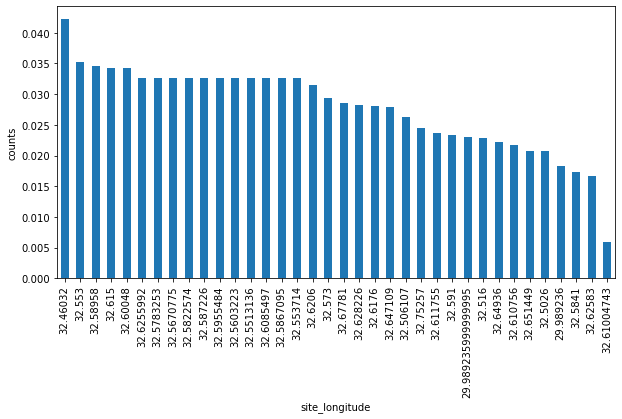

In [37]:
print(data['site_longitude'].value_counts())
plt.figure(figsize=(10,5))
data['site_longitude'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('site_longitude')

### Only one is imbalanced 
* geo_code
* count_encode

## Label_Encoding

In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le_columns = [col for col in data.select_dtypes('object').columns if col not in ['ID']]

for col in le_columns:
   data[col] = le.fit_transform(data[col])

In [39]:
data.head(2)

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5
0,ID_CE4DAC712J,2019-03-14,12,0.05960,32.46032,0.84658,22.64167,0.03055,2888.99756,404.19510,829761.25000,-98.10632,26.89892,-95.52778,23.62301,-0.00004,0.87017,-0.00009,0.11689,28.23592,-95.52691,52.51348,-98.33331,-0.70344,829857.37500,-98.33331,52.51348,-95.52691,28.23592,0.12068,2.70948,0.33188,233.32375,0.11983,-98.33331,52.51348,-95.52691,28.23592,0.17720,25944.07045,9897.85641,30049.92433,8889.99246,5.46729,0.20684,-98.33607,52.51367,-95.49016,28.23713,31.41500
1,ID_HIQKM4CT8J,2019-03-15,12,0.05960,32.46032,0.78383,24.32500,0.03055,2888.99756,404.19510,829761.25000,-98.10632,26.89892,-95.52778,23.62301,0.00011,0.82960,0.00003,0.02380,23.58415,-95.56614,26.63700,-100.67177,-1.18423,829779.75000,-100.67177,26.63700,-95.56614,23.58415,0.12111,2.20115,0.26946,228.39670,0.02458,-100.67177,26.63700,-95.56614,23.58415,0.02458,80723.17188,1156.24426,88145.25000,1156.24426,5.07760,0.24149,-100.67178,26.63713,-95.56615,23.58417,28.94000


In [40]:
# Convert datetime variables to datetime objects
data["date"] = pd.to_datetime(data.date)


In [41]:
data.head(2)

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5
0,ID_CE4DAC712J,2019-03-14,12,0.05960,32.46032,0.84658,22.64167,0.03055,2888.99756,404.19510,829761.25000,-98.10632,26.89892,-95.52778,23.62301,-0.00004,0.87017,-0.00009,0.11689,28.23592,-95.52691,52.51348,-98.33331,-0.70344,829857.37500,-98.33331,52.51348,-95.52691,28.23592,0.12068,2.70948,0.33188,233.32375,0.11983,-98.33331,52.51348,-95.52691,28.23592,0.17720,25944.07045,9897.85641,30049.92433,8889.99246,5.46729,0.20684,-98.33607,52.51367,-95.49016,28.23713,31.41500
1,ID_HIQKM4CT8J,2019-03-15,12,0.05960,32.46032,0.78383,24.32500,0.03055,2888.99756,404.19510,829761.25000,-98.10632,26.89892,-95.52778,23.62301,0.00011,0.82960,0.00003,0.02380,23.58415,-95.56614,26.63700,-100.67177,-1.18423,829779.75000,-100.67177,26.63700,-95.56614,23.58415,0.12111,2.20115,0.26946,228.39670,0.02458,-100.67177,26.63700,-95.56614,23.58415,0.02458,80723.17188,1156.24426,88145.25000,1156.24426,5.07760,0.24149,-100.67178,26.63713,-95.56615,23.58417,28.94000


In [42]:
def time_of_day(number):
  if(number>5 and number<12):
    return(1)
  elif(number>12 and number<17):
    return(2)
  else:
    return(3)

## FEATURE ENGINEERING

In [43]:
# data['lat_lon'] = data['site_latitude'] + data['site_longitude']

In [44]:
date_groups= data.groupby('device').agg(


             humidity_min = ("humidity", "min"),
             humidity_max = ("humidity", "max"),
             humidity_mean = ("humidity", "mean"),
             humidity_sum = ("humidity", "sum"),
    
             temp_mean_min = ("temp_mean", "min"),
             temp_mean_max = ("temp_mean", "max"),
             temp_mean_mean = ("temp_mean", "mean"),
             temp_mean_sum = ("temp_mean", "sum"),    
  
             
             ).reset_index()



In [45]:
data = pd.merge(data,date_groups,on=['device'],how ='left')
data.shape

(14177, 58)

In [46]:
lag_cols =['CarbonMonoxide_CO_column_number_density']

for col in lag_cols:

    for i in range(1, 2):#
        data[f'prev_{col}_{i}'] = data.groupby('device')[col].shift(i)
        

In [47]:
# date_groups.apply(lambda x: len(x.unique()))

In [48]:
data.head()

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5,humidity_min,humidity_max,humidity_mean,humidity_sum,temp_mean_min,temp_mean_max,temp_mean_mean,temp_mean_sum,prev_CarbonMonoxide_CO_column_number_density_1
0,ID_CE4DAC712J,2019-03-14,12,0.05960,32.46032,0.84658,22.64167,0.03055,2888.99756,404.19510,829761.25000,-98.10632,26.89892,-95.52778,23.62301,-0.00004,0.87017,-0.00009,0.11689,28.23592,-95.52691,52.51348,-98.33331,-0.70344,829857.37500,-98.33331,52.51348,-95.52691,28.23592,0.12068,2.70948,0.33188,233.32375,0.11983,-98.33331,52.51348,-95.52691,28.23592,0.17720,25944.07045,9897.85641,30049.92433,8889.99246,5.46729,0.20684,-98.33607,52.51367,-95.49016,28.23713,31.41500,0.49082,0.92006,0.79686,476.51944,18.60382,25.81285,22.47213,13438.33599,NaN
1,ID_HIQKM4CT8J,2019-03-15,12,0.05960,32.46032,0.78383,24.32500,0.03055,2888.99756,404.19510,829761.25000,-98.10632,26.89892,-95.52778,23.62301,0.00011,0.82960,0.00003,0.02380,23.58415,-95.56614,26.63700,-100.67177,-1.18423,829779.75000,-100.67177,26.63700,-95.56614,23.58415,0.12111,2.20115,0.26946,228.39670,0.02458,-100.67177,26.63700,-95.56614,23.58415,0.02458,80723.17188,1156.24426,88145.25000,1156.24426,5.07760,0.24149,-100.67178,26.63713,-95.56615,23.58417,28.94000,0.49082,0.92006,0.79686,476.51944,18.60382,25.81285,22.47213,13438.33599,0.03055
2,ID_RBKKDULJSK,2019-03-16,12,0.05960,32.46032,0.74197,25.72500,0.03222,1813.22327,1.00000,829616.93750,71.08754,11.98861,-95.62900,18.94931,0.00005,0.85317,-0.00003,0.03085,18.96173,-95.64590,11.73769,76.47845,-0.45510,829634.25000,76.47845,11.73769,-95.64590,18.96173,0.12141,2.08385,0.25670,231.32063,0.03215,76.47845,11.73769,-95.64590,18.96173,0.03193,88152.93659,1156.24155,88152.93659,1156.24155,5.07578,0.22140,76.47902,11.73047,-95.64629,18.96258,34.34927,0.49082,0.92006,0.79686,476.51944,18.60382,25.81285,22.47213,13438.33599,0.03055
3,ID_AAI6SF03WX,2019-03-17,12,0.05960,32.46032,0.74805,24.60799,0.03199,2115.60107,1476.04944,829422.00000,71.80083,43.62222,-95.74232,14.41078,0.00012,0.97461,0.00004,0.00000,14.36011,-95.70810,43.74266,73.62637,-1.57375,829445.12500,73.62637,43.74266,-95.70810,14.36011,0.12082,2.39525,0.29515,229.09546,0.00000,73.62637,43.74266,-95.70810,14.36011,0.03193,88152.93659,1156.24155,88152.93659,1156.24155,5.07578,0.22140,76.47902,11.73047,-95.64629,18.96258,43.13188,0.49082,0.92006,0.79686,476.51944,18.60382,25.81285,22.47213,13438.33599,0.03222
4,ID_TBMFQGXQ5D,2019-03-18,12,0.05960,32.46032,0.73558,24.85764,0.02998,1881.76721,173.60150,829230.25000,70.01245,62.22473,-96.36127,9.83084,0.00022,1.11088,0.00017,0.01037,9.75671,-96.19568,62.29021,71.64646,-1.28146,829263.12500,71.646

In [49]:
# # data['date'].nunique(),train['date'].nunique(),test['date'].nunique(),train.shape,test.shape
# data['lat_lon'].nunique()

## Feature Interactions

In [50]:
# # Extract day, month year and hour from the Datetime column
# # day

# # month
data['Datetime_month'] = data.date.dt.month
# data['weekofyear'] = data.date.dt.weekofyear
 
# # year
# data['Datetime_year'] = data.date.dt.year

# # hour
# data['Datetime_hour'] = data.date.dt.hour

# data['weekday'] =data.date.dt.weekday

# data['month_day'] = data['Datetime_month'].astype(str) + '_' + data['Datetime_day'].astype(str)
# data['month_wkday'] = data['Datetime_month'].astype(str) + '_' + data['weekday'].astype(str)



In [51]:
# data.apply(lambda x: len(x.unique()))

In [52]:
# data.drop("date", axis = 1, inplace = True)

In [53]:
data.head(10)

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5,humidity_min,humidity_max,humidity_mean,humidity_sum,temp_mean_min,temp_mean_max,temp_mean_mean,temp_mean_sum,prev_CarbonMonoxide_CO_column_number_density_1,Datetime_month
0,ID_CE4DAC712J,2019-03-14,12,0.05960,32.46032,0.84658,22.64167,0.03055,2888.99756,404.19510,829761.25000,-98.10632,26.89892,-95.52778,23.62301,-0.00004,0.87017,-0.00009,0.11689,28.23592,-95.52691,52.51348,-98.33331,-0.70344,829857.37500,-98.33331,52.51348,-95.52691,28.23592,0.12068,2.70948,0.33188,233.32375,0.11983,-98.33331,52.51348,-95.52691,28.23592,0.17720,25944.07045,9897.85641,30049.92433,8889.99246,5.46729,0.20684,-98.33607,52.51367,-95.49016,28.23713,31.41500,0.49082,0.92006,0.79686,476.51944,18.60382,25.81285,22.47213,13438.33599,NaN,3
1,ID_HIQKM4CT8J,2019-03-15,12,0.05960,32.46032,0.78383,24.32500,0.03055,2888.99756,404.19510,829761.25000,-98.10632,26.89892,-95.52778,23.62301,0.00011,0.82960,0.00003,0.02380,23.58415,-95.56614,26.63700,-100.67177,-1.18423,829779.75000,-100.67177,26.63700,-95.56614,23.58415,0.12111,2.20115,0.26946,228.39670,0.02458,-100.67177,26.63700,-95.56614,23.58415,0.02458,80723.17188,1156.24426,88145.25000,1156.24426,5.07760,0.24149,-100.67178,26.63713,-95.56615,23.58417,28.94000,0.49082,0.92006,0.79686,476.51944,18.60382,25.81285,22.47213,13438.33599,0.03055,3
2,ID_RBKKDULJSK,2019-03-16,12,0.05960,32.46032,0.74197,25.72500,0.03222,1813.22327,1.00000,829616.93750,71.08754,11.98861,-95.62900,18.94931,0.00005,0.85317,-0.00003,0.03085,18.96173,-95.64590,11.73769,76.47845,-0.45510,829634.25000,76.47845,11.73769,-95.64590,18.96173,0.12141,2.08385,0.25670,231.32063,0.03215,76.47845,11.73769,-95.64590,18.96173,0.03193,88152.93659,1156.24155,88152.93659,1156.24155,5.07578,0.22140,76.47902,11.73047,-95.64629,18.96258,34.34927,0.49082,0.92006,0.79686,476.51944,18.60382,25.81285,22.47213,13438.33599,0.03055,3
3,ID_AAI6SF03WX,2019-03-17,12,0.05960,32.46032,0.74805,24.60799,0.03199,2115.60107,1476.04944,829422.00000,71.80083,43.62222,-95.74232,14.41078,0.00012,0.97461,0.00004,0.00000,14.36011,-95.70810,43.74266,73.62637,-1.57375,829445.12500,73.62637,43.74266,-95.70810,14.36011,0.12082,2.39525,0.29515,229.09546,0.00000,73.62637,43.74266,-95.70810,14.36011,0.03193,88152.93659,1156.24155,88152.93659,1156.24155,5.07578,0.22140,76.47902,11.73047,-95.64629,18.96258,43.13188,0.49082,0.92006,0.79686,476.51944,18.60382,25.81285,22.47213,13438.33599,0.03222,3
4,ID_TBMFQGXQ5D,2019-03-18,12,0.05960,32.46032,0.73558,24.85764,0.02998,1881.76721,173.60150,829230.25000,70.01245,62.22473,-96.36127,9.83084,0.00022,1.11088,0.00017,0.01037,9.75671,-96.19568,62.29021,71.64646,-1.28

More Visualizations

In [54]:
cat_cols = ['device',]

## Count of unique features
for i in cat_cols:
    data['count_'+i] = data[i].map(data[i].value_counts())
# cat_cols

In [55]:
data['month_sin'] = np.sin((data['Datetime_month']-1)*(2.0 * np.pi/12))
data['month_cos'] = np.cos((data['Datetime_month']-1)*(2.0 * np.pi/12))



In [56]:
# data['humidity_bins'] = pd.cut(data['humidity'], 5)
# data['temp_mean_bins'] = pd.cut(data['temp_mean'], 5)


In [57]:

# le_columns = ['humidity_bins','temp_mean_bins']

# for col in le_columns:
#    data[col] = le.fit_transform(data[col])


In [58]:
data.head()

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5,humidity_min,humidity_max,humidity_mean,humidity_sum,temp_mean_min,temp_mean_max,temp_mean_mean,temp_mean_sum,prev_CarbonMonoxide_CO_column_number_density_1,Datetime_month,count_device,month_sin,month_cos
0,ID_CE4DAC712J,2019-03-14,12,0.05960,32.46032,0.84658,22.64167,0.03055,2888.99756,404.19510,829761.25000,-98.10632,26.89892,-95.52778,23.62301,-0.00004,0.87017,-0.00009,0.11689,28.23592,-95.52691,52.51348,-98.33331,-0.70344,829857.37500,-98.33331,52.51348,-95.52691,28.23592,0.12068,2.70948,0.33188,233.32375,0.11983,-98.33331,52.51348,-95.52691,28.23592,0.17720,25944.07045,9897.85641,30049.92433,8889.99246,5.46729,0.20684,-98.33607,52.51367,-95.49016,28.23713,31.41500,0.49082,0.92006,0.79686,476.51944,18.60382,25.81285,22.47213,13438.33599,NaN,3,598,0.86603,0.50000
1,ID_HIQKM4CT8J,2019-03-15,12,0.05960,32.46032,0.78383,24.32500,0.03055,2888.99756,404.19510,829761.25000,-98.10632,26.89892,-95.52778,23.62301,0.00011,0.82960,0.00003,0.02380,23.58415,-95.56614,26.63700,-100.67177,-1.18423,829779.75000,-100.67177,26.63700,-95.56614,23.58415,0.12111,2.20115,0.26946,228.39670,0.02458,-100.67177,26.63700,-95.56614,23.58415,0.02458,80723.17188,1156.24426,88145.25000,1156.24426,5.07760,0.24149,-100.67178,26.63713,-95.56615,23.58417,28.94000,0.49082,0.92006,0.79686,476.51944,18.60382,25.81285,22.47213,13438.33599,0.03055,3,598,0.86603,0.50000
2,ID_RBKKDULJSK,2019-03-16,12,0.05960,32.46032,0.74197,25.72500,0.03222,1813.22327,1.00000,829616.93750,71.08754,11.98861,-95.62900,18.94931,0.00005,0.85317,-0.00003,0.03085,18.96173,-95.64590,11.73769,76.47845,-0.45510,829634.25000,76.47845,11.73769,-95.64590,18.96173,0.12141,2.08385,0.25670,231.32063,0.03215,76.47845,11.73769,-95.64590,18.96173,0.03193,88152.93659,1156.24155,88152.93659,1156.24155,5.07578,0.22140,76.47902,11.73047,-95.64629,18.96258,34.34927,0.49082,0.92006,0.79686,476.51944,18.60382,25.81285,22.47213,13438.33599,0.03055,3,598,0.86603,0.50000
3,ID_AAI6SF03WX,2019-03-17,12,0.05960,32.46032,0.74805,24.60799,0.03199,2115.60107,1476.04944,829422.00000,71.80083,43.62222,-95.74232,14.41078,0.00012,0.97461,0.00004,0.00000,14.36011,-95.70810,43.74266,73.62637,-1.57375,829445.12500,73.62637,43.74266,-95.70810,14.36011,0.12082,2.39525,0.29515,229.09546,0.00000,73.62637,43.74266,-95.70810,14.36011,0.03193,88152.93659,1156.24155,88152.93659,1156.24155,5.07578,0.22140,76.47902,11.73047,-95.64629,18.96258,43.13188,0.49082,0.92006,0.79686,476.51944,18.60382,25.81285,22.47213,13438.33599,0.03222,3,598,0.86603,0.50000
4,ID_TBMFQGXQ5D,2019-03-18,12,0.05960,32.46032,0.73558,24.85764,0.02998,1881.76721,173.60150,829230.25

### well the curve keeps increasing with months

In [59]:
# cat_cols = ['device','lat_lon','site_latitude','site_longitude','weekday','month_day','month_wkday','humidity','temp_mean',
    
           
#            ]



# ## Count of unique features
# for i in cat_cols:
#     data['count_'+i] = data[i].map(data[i].value_counts())
# # cat_cols

In [60]:
data.shape

(14177, 63)

In [61]:
simple_feats = [c for c in data.columns if ('angle' in c) & ('solar' in c) or ('sensor' in c)]
data = data.drop(columns = simple_feats)
data.columns

Index(['ID', 'date', 'device', 'site_latitude', 'site_longitude', 'humidity',
       'temp_mean', 'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height',
       'Formaldehyde_tropospheric_HCHO_column_number_density',
       'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
       'Formaldehyde_HCHO_slant_column_number_density',
       'Formaldehyde_cloud_fraction', 'UvAerosolIndex_absorbing_aerosol_index',
       'Ozone_O3_column_number_density', 'Ozone_O3_column_number_density_amf',
       'Ozone_O3_slant_column_number_density',
       'Ozone_O3_effective_temperature', 'Ozone_cloud_fraction',
       'Cloud_cloud_fraction', 'Cloud_cloud_top_pressure',
       'Cloud_cloud_top_height', 'Cloud_cloud_base_pressure',
       'Cloud_cloud_base_height', 'Cloud_cloud_optical_depth',
       'Cloud_surface_albedo', 'pm2_5', 'humidity_min', 'humidity_max',
       'humidity_mean', 'humidity_sum', 'temp_mean_min', 

### Separate the train and test

In [62]:
# Separate train and test data from the combined dataframe
# data = data.drop("ID", axis = 1)
train_df = data[:ntrain]
test_df = data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((9923, 41), (4254, 41))

In [64]:
# train_df.to_csv('new_train.csv',index=False)
# test_df.to_csv('new_test.csv',index=False)
# train.shape,test.shape

### Negative Correlation

In [65]:
# train_df.corr()['pm2_5'].sort_values()[train_df.corr()['pm2_5'].sort_values() < 0]

### Positive Correlation

In [66]:
# train_df.corr()['pm2_5'].sort_values()[train_df.corr()['pm2_5'].sort_values() > 0]

In [67]:
# DevicePM2_5Mean = dict(train_df.groupby('device')['pm2_5'].mean())
# # DevicePM2_5Std = dict(train_df.groupby('device')['pm2_5'].std())
# # DevicePM2_5Min = dict(train_df.groupby('device')['pm2_5'].min())
# # DevicePM2_5Max = dict(train_df.groupby('device')['pm2_5'].max())

# for dataset in (train_df,test_df):
#     dataset['DevicePM2_5Mean'] = dataset['device'].map(DevicePM2_5Mean)

## FEATURE SELECTION

In [68]:
# train_df['Datetime_year'].value_counts()

In [69]:
# test_df['Datetime_year'].value_counts()

In [70]:
training = train_df[train_df.date <= '2020-07-21 00:00:00']
validation = train_df[train_df.date > '2020-07-21 00:00:00']
training.shape,validation.shape

((8954, 63), (969, 63))

In [71]:

# le_columns = ['date']

# for col in le_columns:
#    train_df[col] = le.fit_transform(train_df[col])
#    test_df[col] = le.fit_transform(test_df[col])
#    training[col] = le.fit_transform(training[col])
#    validation[col] = le.fit_transform(validation[col])

In [72]:
# Select main columns to be used in training
main_cols = training.columns.difference([
    'ID','pm2_5','bearing'
]
    )
X_train = training[main_cols]
y_train = training.pm2_5
X_valid = validation[main_cols]
y_valid = validation.pm2_5
X_test = test_df[X_train.columns]
X_train.shape,X_valid.shape,y_train.shape,y_valid.shape, X_test.shape

((8954, 61), (969, 61), (8954,), (969,), (4254, 61))

In [73]:
data.columns

Index(['ID', 'date', 'device', 'site_latitude', 'site_longitude', 'humidity',
       'temp_mean', 'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height',
       'Formaldehyde_tropospheric_HCHO_column_number_density',
       'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
       'Formaldehyde_HCHO_slant_column_number_density',
       'Formaldehyde_cloud_fraction', 'UvAerosolIndex_absorbing_aerosol_index',
       'Ozone_O3_column_number_density', 'Ozone_O3_column_number_density_amf',
       'Ozone_O3_slant_column_number_density',
       'Ozone_O3_effective_temperature', 'Ozone_cloud_fraction',
       'Cloud_cloud_fraction', 'Cloud_cloud_top_pressure',
       'Cloud_cloud_top_height', 'Cloud_cloud_base_pressure',
       'Cloud_cloud_base_height', 'Cloud_cloud_optical_depth',
       'Cloud_surface_albedo', 'pm2_5', 'humidity_min', 'humidity_max',
       'humidity_mean', 'humidity_sum', 'temp_mean_min', 

In [74]:

params = {'max_depth': 5, 'learning_rate': 0.054311625828468046, 'l2_leaf_reg': 0.023393133390917083,'iterations':3000}
model = catt.CatBoostRegressor(**params,eval_metric='MAE',random_state=42)


model.fit(X_train, y_train ,eval_set = [(X_train, y_train),(X_valid,y_valid)], early_stopping_rounds = 250, 
          verbose = 200)

0:	learn: 19.2932120	test: 19.2932120	test1: 22.2106793	best: 22.2106793 (0)	total: 59.2ms	remaining: 2m 57s
200:	learn: 8.5863537	test: 8.5863537	test1: 13.4285202	best: 13.4285202 (200)	total: 1.37s	remaining: 19.1s
400:	learn: 6.8760888	test: 6.8760888	test1: 13.1001890	best: 13.0819947 (386)	total: 2.65s	remaining: 17.2s
600:	learn: 6.0082001	test: 6.0082001	test1: 13.0419974	best: 13.0035143 (469)	total: 3.95s	remaining: 15.8s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 13.00351429
bestIteration = 469

Shrink model to first 470 iterations.


All_feats + fillna() - 14.43262175

All_feats + groupbyfill() -  13.21442942

All_fetas + drop(>40 % missing values) - 12.90005666

Dropping angle features - 12.79649109

0.97 percentile on pm2_5 = 12.58010363
0.97 percentile on Cloud_cloud_optical_depth = 12.54106953

count_device =12.46935985
Datetime_month = 12.45655687
Groupby device = 12.37322771
Lag_Carbon_density = 12.33457964
Cyclical_month = 11.91526031
rem 'Cloud_cloud_optical_depth' 11.90311256 

In [75]:
pd.options.display.max_rows = 2200
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_columns, max_vars=350):
    
    # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df
#
get_catt_varimp(model, X_train.columns)

,feature_name,varimp (%)
41,month_sin,11.65029
0,CarbonMonoxide_CO_column_number_density,9.48222
22,date,7.32816
29,humidity_min,7.30286
49,temp_mean_mean,6.70891
23,device,5.54649
43,site_latitude,3.97345
44,site_longitude,3.05532
1,CarbonMonoxide_H2O_column_number_density,2.61334
40,month_cos,2.56098


In [76]:
params = {'max_depth': 5, 'learning_rate': 0.054311625828468046, 'l2_leaf_reg': 0.023393133390917083,'iterations':1500}
model = catt.CatBoostRegressor(**params,eval_metric='MAE',random_state=42)
model.fit(train_df[main_cols],train_df['pm2_5'])
preds = model.predict(X_test)
preds.shape

0:	learn: 19.7707880	total: 10.4ms	remaining: 15.5s
1:	learn: 19.3343839	total: 19.8ms	remaining: 14.9s
2:	learn: 18.9004379	total: 28.7ms	remaining: 14.3s
3:	learn: 18.4947025	total: 35.7ms	remaining: 13.3s
4:	learn: 18.1071036	total: 42.5ms	remaining: 12.7s
5:	learn: 17.7603633	total: 49.1ms	remaining: 12.2s
6:	learn: 17.4109428	total: 59.5ms	remaining: 12.7s
7:	learn: 17.0993455	total: 66ms	remaining: 12.3s
8:	learn: 16.7997479	total: 72.7ms	remaining: 12s
9:	learn: 16.5491501	total: 79.2ms	remaining: 11.8s
10:	learn: 16.2914682	total: 88.5ms	remaining: 12s
11:	learn: 16.0520524	total: 95.1ms	remaining: 11.8s
12:	learn: 15.8115676	total: 102ms	remaining: 11.6s
13:	learn: 15.6064845	total: 109ms	remaining: 11.6s
14:	learn: 15.4051307	total: 116ms	remaining: 11.5s
15:	learn: 15.2345742	total: 122ms	remaining: 11.4s
16:	learn: 15.0716739	total: 129ms	remaining: 11.3s
17:	learn: 14.9074266	total: 136ms	remaining: 11.2s
18:	learn: 14.7570451	total: 142ms	remaining: 11.1s
19:	learn: 14.61

172:	learn: 9.1959479	total: 1.43s	remaining: 11s
173:	learn: 9.1837494	total: 1.44s	remaining: 10.9s
174:	learn: 9.1544430	total: 1.44s	remaining: 10.9s
175:	learn: 9.1422363	total: 1.45s	remaining: 10.9s
176:	learn: 9.1327387	total: 1.46s	remaining: 10.9s
177:	learn: 9.1194077	total: 1.47s	remaining: 10.9s
178:	learn: 9.1098558	total: 1.48s	remaining: 10.9s
179:	learn: 9.0971562	total: 1.49s	remaining: 10.9s
180:	learn: 9.0859859	total: 1.49s	remaining: 10.9s
181:	learn: 9.0759674	total: 1.5s	remaining: 10.9s
182:	learn: 9.0542952	total: 1.51s	remaining: 10.8s
183:	learn: 9.0329857	total: 1.51s	remaining: 10.8s
184:	learn: 9.0080066	total: 1.52s	remaining: 10.8s
185:	learn: 9.0002982	total: 1.53s	remaining: 10.8s
186:	learn: 8.9890247	total: 1.53s	remaining: 10.8s
187:	learn: 8.9755034	total: 1.54s	remaining: 10.7s
188:	learn: 8.9591284	total: 1.55s	remaining: 10.7s
189:	learn: 8.9460933	total: 1.55s	remaining: 10.7s
190:	learn: 8.9229838	total: 1.56s	remaining: 10.7s
191:	learn: 8.9

350:	learn: 7.3535051	total: 2.83s	remaining: 9.26s
351:	learn: 7.3454363	total: 2.84s	remaining: 9.26s
352:	learn: 7.3402850	total: 2.85s	remaining: 9.25s
353:	learn: 7.3344242	total: 2.86s	remaining: 9.26s
354:	learn: 7.3271301	total: 2.87s	remaining: 9.26s
355:	learn: 7.3217529	total: 2.88s	remaining: 9.26s
356:	learn: 7.3111098	total: 2.89s	remaining: 9.25s
357:	learn: 7.3040274	total: 2.9s	remaining: 9.24s
358:	learn: 7.2975882	total: 2.91s	remaining: 9.24s
359:	learn: 7.2937443	total: 2.91s	remaining: 9.22s
360:	learn: 7.2852275	total: 2.92s	remaining: 9.21s
361:	learn: 7.2792395	total: 2.93s	remaining: 9.2s
362:	learn: 7.2730560	total: 2.93s	remaining: 9.19s
363:	learn: 7.2678082	total: 2.94s	remaining: 9.17s
364:	learn: 7.2591265	total: 2.94s	remaining: 9.16s
365:	learn: 7.2523621	total: 2.95s	remaining: 9.15s
366:	learn: 7.2440675	total: 2.96s	remaining: 9.13s
367:	learn: 7.2356863	total: 2.96s	remaining: 9.12s
368:	learn: 7.2294391	total: 2.97s	remaining: 9.11s
369:	learn: 7.

511:	learn: 6.5035290	total: 4.03s	remaining: 7.78s
512:	learn: 6.4983757	total: 4.04s	remaining: 7.77s
513:	learn: 6.4958774	total: 4.05s	remaining: 7.76s
514:	learn: 6.4907674	total: 4.06s	remaining: 7.76s
515:	learn: 6.4865401	total: 4.07s	remaining: 7.75s
516:	learn: 6.4838455	total: 4.07s	remaining: 7.75s
517:	learn: 6.4801839	total: 4.08s	remaining: 7.74s
518:	learn: 6.4774225	total: 4.09s	remaining: 7.73s
519:	learn: 6.4724960	total: 4.1s	remaining: 7.72s
520:	learn: 6.4667187	total: 4.1s	remaining: 7.71s
521:	learn: 6.4636972	total: 4.11s	remaining: 7.7s
522:	learn: 6.4599061	total: 4.12s	remaining: 7.69s
523:	learn: 6.4561918	total: 4.12s	remaining: 7.68s
524:	learn: 6.4514673	total: 4.13s	remaining: 7.67s
525:	learn: 6.4484813	total: 4.13s	remaining: 7.66s
526:	learn: 6.4431242	total: 4.14s	remaining: 7.65s
527:	learn: 6.4391888	total: 4.15s	remaining: 7.64s
528:	learn: 6.4366971	total: 4.16s	remaining: 7.63s
529:	learn: 6.4338196	total: 4.16s	remaining: 7.62s
530:	learn: 6.4

677:	learn: 5.9107690	total: 5.23s	remaining: 6.34s
678:	learn: 5.9077776	total: 5.25s	remaining: 6.34s
679:	learn: 5.9024665	total: 5.25s	remaining: 6.33s
680:	learn: 5.8981146	total: 5.26s	remaining: 6.33s
681:	learn: 5.8943926	total: 5.27s	remaining: 6.32s
682:	learn: 5.8922867	total: 5.28s	remaining: 6.32s
683:	learn: 5.8889990	total: 5.29s	remaining: 6.31s
684:	learn: 5.8856637	total: 5.3s	remaining: 6.3s
685:	learn: 5.8841697	total: 5.3s	remaining: 6.29s
686:	learn: 5.8812539	total: 5.31s	remaining: 6.28s
687:	learn: 5.8781580	total: 5.32s	remaining: 6.27s
688:	learn: 5.8737117	total: 5.32s	remaining: 6.26s
689:	learn: 5.8714287	total: 5.33s	remaining: 6.26s
690:	learn: 5.8681057	total: 5.34s	remaining: 6.25s
691:	learn: 5.8649398	total: 5.34s	remaining: 6.24s
692:	learn: 5.8624231	total: 5.35s	remaining: 6.23s
693:	learn: 5.8601017	total: 5.36s	remaining: 6.22s
694:	learn: 5.8551703	total: 5.36s	remaining: 6.21s
695:	learn: 5.8517511	total: 5.37s	remaining: 6.2s
696:	learn: 5.84

860:	learn: 5.4177900	total: 6.62s	remaining: 4.92s
861:	learn: 5.4145387	total: 6.63s	remaining: 4.91s
862:	learn: 5.4128146	total: 6.64s	remaining: 4.9s
863:	learn: 5.4107835	total: 6.65s	remaining: 4.89s
864:	learn: 5.4085864	total: 6.66s	remaining: 4.89s
865:	learn: 5.4068392	total: 6.67s	remaining: 4.88s
866:	learn: 5.4050433	total: 6.67s	remaining: 4.87s
867:	learn: 5.4036431	total: 6.69s	remaining: 4.87s
868:	learn: 5.4002391	total: 6.69s	remaining: 4.86s
869:	learn: 5.3984824	total: 6.7s	remaining: 4.85s
870:	learn: 5.3963081	total: 6.71s	remaining: 4.84s
871:	learn: 5.3931185	total: 6.71s	remaining: 4.83s
872:	learn: 5.3907690	total: 6.72s	remaining: 4.83s
873:	learn: 5.3883352	total: 6.72s	remaining: 4.82s
874:	learn: 5.3864715	total: 6.73s	remaining: 4.81s
875:	learn: 5.3840971	total: 6.74s	remaining: 4.8s
876:	learn: 5.3821067	total: 6.75s	remaining: 4.79s
877:	learn: 5.3798724	total: 6.75s	remaining: 4.78s
878:	learn: 5.3779199	total: 6.76s	remaining: 4.77s
879:	learn: 5.3

1021:	learn: 5.0693831	total: 7.83s	remaining: 3.66s
1022:	learn: 5.0667487	total: 7.83s	remaining: 3.65s
1023:	learn: 5.0650143	total: 7.85s	remaining: 3.65s
1024:	learn: 5.0635255	total: 7.86s	remaining: 3.64s
1025:	learn: 5.0612854	total: 7.86s	remaining: 3.63s
1026:	learn: 5.0598897	total: 7.87s	remaining: 3.63s
1027:	learn: 5.0583167	total: 7.88s	remaining: 3.62s
1028:	learn: 5.0564146	total: 7.89s	remaining: 3.61s
1029:	learn: 5.0551783	total: 7.9s	remaining: 3.6s
1030:	learn: 5.0535868	total: 7.91s	remaining: 3.6s
1031:	learn: 5.0520330	total: 7.91s	remaining: 3.59s
1032:	learn: 5.0500285	total: 7.92s	remaining: 3.58s
1033:	learn: 5.0481991	total: 7.92s	remaining: 3.57s
1034:	learn: 5.0463617	total: 7.93s	remaining: 3.56s
1035:	learn: 5.0446720	total: 7.94s	remaining: 3.56s
1036:	learn: 5.0416508	total: 7.95s	remaining: 3.55s
1037:	learn: 5.0402137	total: 7.95s	remaining: 3.54s
1038:	learn: 5.0386521	total: 7.96s	remaining: 3.53s
1039:	learn: 5.0371626	total: 7.96s	remaining: 3.

1204:	learn: 4.7389494	total: 9.23s	remaining: 2.26s
1205:	learn: 4.7370725	total: 9.24s	remaining: 2.25s
1206:	learn: 4.7347366	total: 9.25s	remaining: 2.25s
1207:	learn: 4.7333361	total: 9.26s	remaining: 2.24s
1208:	learn: 4.7309736	total: 9.27s	remaining: 2.23s
1209:	learn: 4.7294474	total: 9.28s	remaining: 2.22s
1210:	learn: 4.7274206	total: 9.29s	remaining: 2.22s
1211:	learn: 4.7257399	total: 9.29s	remaining: 2.21s
1212:	learn: 4.7230658	total: 9.3s	remaining: 2.2s
1213:	learn: 4.7205324	total: 9.31s	remaining: 2.19s
1214:	learn: 4.7194690	total: 9.31s	remaining: 2.18s
1215:	learn: 4.7183162	total: 9.32s	remaining: 2.18s
1216:	learn: 4.7168526	total: 9.33s	remaining: 2.17s
1217:	learn: 4.7150993	total: 9.33s	remaining: 2.16s
1218:	learn: 4.7134760	total: 9.34s	remaining: 2.15s
1219:	learn: 4.7117844	total: 9.35s	remaining: 2.14s
1220:	learn: 4.7098618	total: 9.35s	remaining: 2.14s
1221:	learn: 4.7083230	total: 9.36s	remaining: 2.13s
1222:	learn: 4.7065410	total: 9.37s	remaining: 2

1371:	learn: 4.4685158	total: 10.4s	remaining: 974ms
1372:	learn: 4.4670639	total: 10.4s	remaining: 966ms
1373:	learn: 4.4655118	total: 10.5s	remaining: 959ms
1374:	learn: 4.4637732	total: 10.5s	remaining: 951ms
1375:	learn: 4.4626642	total: 10.5s	remaining: 944ms
1376:	learn: 4.4611826	total: 10.5s	remaining: 936ms
1377:	learn: 4.4602682	total: 10.5s	remaining: 929ms
1378:	learn: 4.4583939	total: 10.5s	remaining: 921ms
1379:	learn: 4.4570373	total: 10.5s	remaining: 913ms
1380:	learn: 4.4556262	total: 10.5s	remaining: 906ms
1381:	learn: 4.4539254	total: 10.5s	remaining: 898ms
1382:	learn: 4.4527030	total: 10.5s	remaining: 890ms
1383:	learn: 4.4510372	total: 10.5s	remaining: 882ms
1384:	learn: 4.4495194	total: 10.5s	remaining: 875ms
1385:	learn: 4.4483641	total: 10.5s	remaining: 867ms
1386:	learn: 4.4468902	total: 10.5s	remaining: 859ms
1387:	learn: 4.4441658	total: 10.6s	remaining: 852ms
1388:	learn: 4.4425105	total: 10.6s	remaining: 844ms
1389:	learn: 4.4409718	total: 10.6s	remaining:

(4254,)

In [77]:
sub_df = test_df[['ID']].copy()
sub_df['pm2_5'] = preds
sub_df.head()

,ID,pm2_5
9923,ID_OC21YTIKX2,64.46719
9924,ID_ZS2RAN8HZT,57.90945
9925,ID_X5RLD131U1,57.68845
9926,ID_3O2ZUT59OO,60.73986
9927,ID_WGF1986WB4,46.27355


In [78]:
sub_df.to_csv('train_test_split_rolling.csv', index=False)

In [ ]:
sns.distplot(sub_df.pm2_5)

## Hyperparameter Tuning

In [ ]:
training = train_df[train_df.date <= '2020-07-21 00:00:00']
validation = train_df[train_df.date > '2020-07-21 00:00:00']
training.shape,validation.shape

In [ ]:
df = pd.concat([validation.assign(ind="test"), training.assign(ind="train")])


In [ ]:
df.head()

In [ ]:

le_columns = ['date']

for col in le_columns:
   df[col] = le.fit_transform(df[col])

df.head()

In [ ]:
validation, training = df[df["ind"].eq("test")], df[df["ind"].eq("train")]

In [ ]:
# Select main columns to be used in training
main_cols = training.columns.difference([
    'ID','pm2_5','ind'
]
    )
X_train = training[main_cols]
y_train = training.pm2_5
X_valid = validation[main_cols]
y_valid = validation.pm2_5
X_test = test_df[X_train.columns]
X_train.shape,X_valid.shape,y_train.shape,y_valid.shape, X_test.shape

In [ ]:
def run(trial): 
    learning_rate     = trial.suggest_float("learning_rate", 0.02, 0.30)
    num_leaves        = trial.suggest_int("num_leaves", 5,50)
    max_depth          = trial.suggest_int("max_depth", 2,20)
    min_child_weight   = trial.suggest_float("min_child_weight", 1,10)
    colsample_bytree   = trial.suggest_float("colsample_bytree", 0.3, 0.9)
    n_estimators       = trial.suggest_int("n_estimators", 150,1000)
    random_state       = trial.suggest_int("random_state", 42,100)
    subsample          = trial.suggest_float("subsample", 0.1, 2.0)
    max_bin            = trial.suggest_int("max_bin", 800,1000)
    feature_fraction   = trial.suggest_float("feature_fraction", 0.20, 0.25)
    bagging_fraction   = trial.suggest_float("bagging_fraction", 0.60, 0.90)
    min_child_samples  =trial.suggest_int("min_child_samples", 100,500)
    reg_alpha          =trial.suggest_float("reg_alpha", 10.00, 80.00)
    reg_lambda         =trial.suggest_float("reg_lambda", 0.00, 100.00)
    min_data_per_group  =trial.suggest_int("min_data_per_group",100,300)
    cat_smooth          = trial.suggest_float("cat_smooth ", 10.0, 100.0)
    cat_l2              =trial.suggest_float("cat_l2" , 10.0, 60.0)
    
    
    model = lgb.LGBMRegressor(objective= 'mae',
                            boosting_type = 'gbdt' ,
                           bagging_freq =1,
                           learning_rate =learning_rate ,
                           num_leaves  =num_leaves  ,
                           max_depth  =max_depth  ,
                           min_child_weight=min_child_weight,
                           colsample_bytree=colsample_bytree,
                           n_estimators =n_estimators ,
                           random_state=random_state,
                           subsample =subsample ,
                           max_bin  =max_bin  ,
                           feature_fraction=feature_fraction,
                           bagging_fraction =bagging_fraction ,
                           min_child_samples =min_child_samples ,
                           reg_alpha=reg_alpha,
                            reg_lambda= reg_lambda,
                            min_data_per_group=  min_data_per_group,
                           cat_smooth    =cat_smooth    ,
                           cat_l2 =cat_l2 
                          )
                           
    model.fit(X_train, y_train ,eval_set = [(X_train, y_train),(X_valid,y_valid)], early_stopping_rounds = 200, 
          verbose = 200)
    
    preds_valid = model.predict(X_valid)
    mae = mean_absolute_error(y_valid,  preds_valid)
    
    return mae

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(run, n_trials=250)

In [ ]:
par=study.best_params
par

In [ ]:
par={'learning_rate': 0.1890337065558107,
 'num_leaves': 34,
 'max_depth': 7,
 'min_child_weight': 2.9127974933090695,
 'colsample_bytree': 0.39864202424310863,
 'n_estimators': 819,
 'random_state': 65,
 'subsample': 0.5435529862124513,
 'max_bin': 894,
 'feature_fraction': 0.246494240574099,
 'bagging_fraction': 0.8998240361555204,
 'min_child_samples': 486,
 'reg_alpha': 28.49080645394865,
 'reg_lambda': 84.76840758107092,
 'min_data_per_group': 254,
 'cat_smooth ': 60.298579850509995,
 'cat_l2': 21.352635283777083}

In [ ]:

model = lgb.LGBMRegressor(**par)


model.fit(X_train, y_train ,eval_set = [(X_train, y_train),(X_valid,y_valid)],eval_metric='mae', early_stopping_rounds = 200, 
          verbose = 50)

In [ ]:

le_columns = ['date']

for col in le_columns:
   data[col] = le.fit_transform(data[col])

data.head()

In [ ]:
# Separate train and test data from the combined dataframe
# data = data.drop("ID", axis = 1)
train_df = data[:ntrain]
test_df = data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

In [ ]:
model = lgb.LGBMRegressor(**par)
model.fit(train_df[main_cols],train_df['pm2_5'])
preds = model.predict(test_df[main_cols])
preds.shape

In [ ]:
sub.pm2_5 = preds
sub.to_csv('tuned_lgb.csv', index=False)
sub.head()
